In [2]:
import json
import os
from moviepy.editor import *
from moviepy import *
import shutil
import numpy as np

from PIL import Image

In [3]:
# Make sure you navigate to the github repo
%cd video-classification-3d-cnn-pytorch/
os.getcwd()

C:\Users\46981\SkillClasses\01_Julian_VideoAndImageClassification\video-classification-3d-cnn-pytorch


'C:\\Users\\46981\\SkillClasses\\01_Julian_VideoAndImageClassification\\video-classification-3d-cnn-pytorch'

In [4]:
# this function loads all films in the folder given as argument into the 'input' file (make sure you are in the right
# directory)

def loadVideosToInfile(folder):
    videos = os.listdir(folder)
    with open('input', 'w') as inputfile:
        for v in videos:
            if v.split('.')[-1] == 'mp4':
                inputfile.write(v+'\n')

In [5]:
# This function should read all .json files in the output folder, and combine them into one large dictionary
def readAllOutput(outputFolder):
    # create an empty dictionary called 'dictionaries' to which you add the dictionary entries read 
    # from the output files
    dictionaries = {}
    
    # Read all output file names to a variable output_files (a list that contains all file names)
    output_files = os.listdir(outputFolder)
    
    # Start of the for loop to loop through all files, read them, and add their contents to 'dictionaries'
    for f in output_files:
        # first test if the file extension is a '.json file'
        if f.endswith('.json'):
            # if it is a json file, we open the file
            file_path = os.path.join(outputFolder, f)
            with open(file_path,'r',encoding='utf-8') as file:
                # Then load the file content to a variable called 'segments' with the json library
                segments = json.load(file)

                # another for loop, to add the content of segments to dictionaries. As a key use the moviename.
                for s in segments:
                    dictionaries[s['video']] = s
    
    return dictionaries


In [6]:
# here keyFilmName is the name of the film that you want to find a match for, and the feature dictionary is 
# the dictionary that is given as output by the readAllOutput function

def searchForMatch(keyFilmName, featureDictionary):
    # create variables to keep track of the best clips
    bestRangeStart = 0
    bestRangeFilmName = ''
    bestRangeScore = 1000000000
    
    # first read the features of the keyFilm into keyFeatures
    keyClips = featureDictionary[keyFilmName]['clips']
    keyFeatures = []
    keyFeatures = [np.array(c['features']) for c in keyClips]
    
    # now enter a for loop to go through all films, and see what the best matching sequence is 
    # (we make sure not to check the keyFilm itself by checking it's not that filename)
    bestMatches = []
    for film in featureDictionary.keys():
        if not film == keyFilmName:
            # so now here 'film' is a filename (which is the key in the feature dictionary of that film)
            # first load the features in a 'filmFeatures' list like we did for key Features
            # then look at the provided code from the lecture to see how to iterate through the other
            # list of features to find the best segment. Now just make sure to also register what film
            # name the best matching segment is from. 
            filmClips = featureDictionary[film]['clips']
            filmFeatures = []
            filmFeatures = [np.array(s['features']) for s in filmClips]
            for i in range(len(filmFeatures)-len(keyFeatures)):
                distance = 0
                for j in range(len(keyFeatures)):
                    d = np.linalg.norm(filmFeatures[i+j]-keyFeatures[j])
                    distance += d
                if distance < bestRangeScore:
                    bestRangeScore = distance
                    bestRangeStart = i
                    bestRangeFilmName = film

                bestMatches.append({
                'bestRangeFilmName': film,
                'bestRangeStart': i,
                'bestRangeScore': distance,
                })
                
   # create a list containing the filename, start and nr of clips
    bestMatches.sort(key=lambda x: x['bestRangeScore'])
    print(bestMatches)
    bestMatches = bestMatches[0]
    
    bestRangeFilmName = bestMatches['bestRangeFilmName']
    bestRangeStart = bestMatches['bestRangeStart']
    
    matchingFragment = [bestRangeFilmName, bestRangeStart, len(keyFeatures)]
    print(matchingFragment)
    
    return matchingFragment

    # First implement it for the best matching one, then expand it to return the n best matching ones as a list,
    # with n as an argument in the function

In [7]:
# this is a helper function to which you give the fragment (the output of the searchForMatch function), and it returns
# a moviepy film object (which you can then save)

def extractFragment(fragment, filmFolder):
    # here adapt the code from the lecture, but make it so that it works for any input fragment list
    # the output of the function above: [bestRangeFilmName, bestRangeStart, len(keyFeatures)]
    
    filmFileName = fragment[0]
    start = fragment[1]*16 #I don't know how the number 16 came about.
    nrClips = fragment[2]*16 #I don't know how the number 16 came about.
    
    film_path = os.path.join(filmFolder, filmFileName)
    film = VideoFileClip(film_path)
    tsfps = film.fps
    tsFrameLength = 1/tsfps
    
    startTime = start * tsFrameLength
    endTime = (start + nrClips) * tsFrameLength 
    
    filmFragment = film.subclip(startTime, endTime)
    
    return filmFragment

    # This function should read all .json files in the output folder, and combine them into one large dictionary

In [8]:
# call function to load the filenames to 'input'
loadVideosToInfile('../input_films')

In [9]:
# run the model to process all films currently in the input_films folder, and save it to a json file, here named by the date

!python main.py --input input --video_root ../input_films --output ../output/output231109.json --model resnet-34-kinetics-cpu.pth --mode feature --no_cuda

loading model resnet-34-kinetics-cpu.pth
../input_films\just-sit-down-shut-up.mp4
../input_films\KillBill.mp4
../input_films\sittingMindhunter.mp4
../input_films\van-der-Elksen-Ed_Handen-aka-Hands_1960.mp4


ffmpeg version 6.0-essentials_build-www.gyan.dev Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.2.0 (Rev10, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libvpl --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --enable-libtheora --enable-libvo-amrwbenc --enable-lib

In [10]:
# a small piece of code that moves all processed input films to the processed films folder

input_films_processed = os.listdir('../input_films')
for file in input_films_processed:
    try:
        shutil.move(os.path.join('../input_films',file),'../processed_films')
    except:
        print(file + ' not moved')

In [11]:
# read all output with the function declared above

dicts = readAllOutput('../output')

In [12]:
# look for the best matching sequence to the input file (needs to be in dicts for it to work)

fragment = searchForMatch('sittingMindhunter.mp4', dicts)

[{'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 4, 'bestRangeScore': 65.25153548433163}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 5, 'bestRangeScore': 66.59767072633664}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 3, 'bestRangeScore': 66.94144211864264}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 2, 'bestRangeScore': 69.50438677895426}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 6, 'bestRangeScore': 69.79086284297233}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 0, 'bestRangeScore': 70.03075645851489}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 14, 'bestRangeScore': 70.30463203718247}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 1, 'bestRangeScore': 70.45865023466334}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 12, 'bestRangeScore': 71.46539491092564}, {'bestR

In [13]:
# extract the fragment from the film

fragmentFilm = extractFragment(fragment, '../processed_films')

In [14]:
# display the film fragment

fragmentFilm.ipython_display()

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [15]:
# save the film fragment


fragmentFilm.write_videofile("../output_films/fragment.mp4", audio_codec='aac')

Moviepy - Building video ../output_films/fragment.mp4.
MoviePy - Writing audio in fragmentTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../output_films/fragment.mp4



Moviepy - Done !
Moviepy - video ready ../output_films/fragment.mp4


# Finding matching fragments with images

### Transfer frame from .jpg to .mp4

In [42]:
video_path = '../ScrapedVideos/KillBill.mp4'
clip = VideoFileClip(video_path)
clip.duration
frame = clip.get_frame(1)

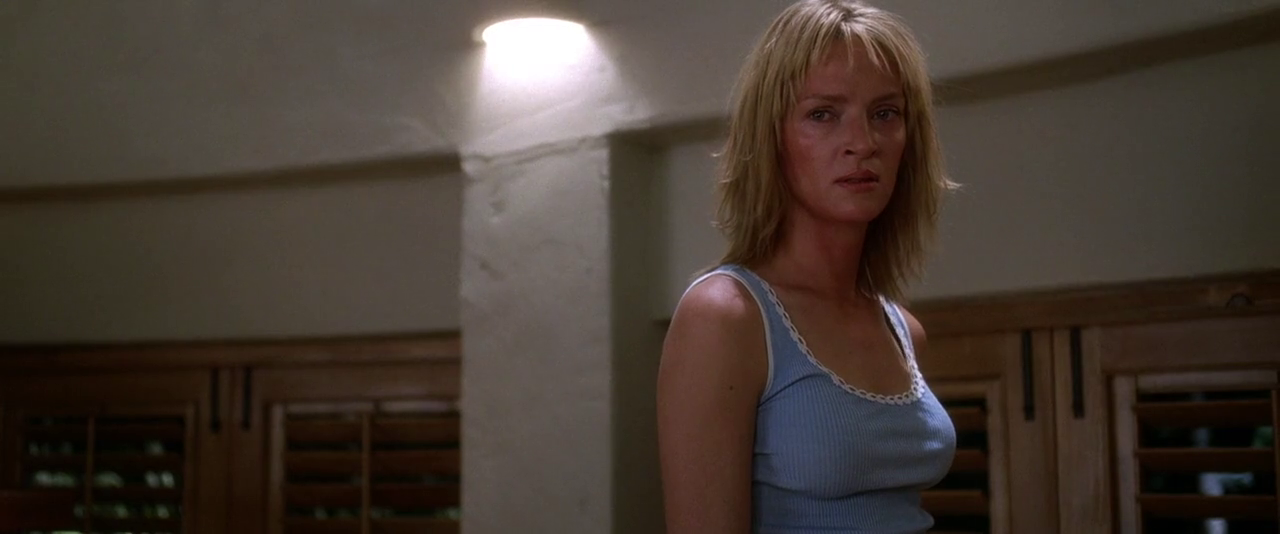

In [43]:
Image.fromarray(frame,'RGB')

In [44]:
image = Image.fromarray(frame,'RGB')
image.save("keyframe.jpg")

In [45]:
image_path = "../video-classification-3d-cnn-pytorch/keyframe.jpg"
video_output_path = "../image_inputfilms/keyframe_video.mp4"
image_clip = ImageClip(image_path, duration=2) 
image_clip.write_videofile(video_output_path, codec="libx264", fps=24)

Moviepy - Building video ../image_inputfilms/keyframe_video.mp4.
Moviepy - Writing video ../image_inputfilms/keyframe_video.mp4



Moviepy - Done !
Moviepy - video ready ../image_inputfilms/keyframe_video.mp4


### Copy the method

In [46]:
loadVideosToInfile('../image_inputfilms')

In [47]:
!python main.py --input input --video_root ../image_inputfilms --output ../image_output/image_output.json --model resnet-34-kinetics-cpu.pth --mode feature --no_cuda

loading model resnet-34-kinetics-cpu.pth
../image_inputfilms\just-sit-down-shut-up.mp4
../image_inputfilms\keyframe_video.mp4
../image_inputfilms\sittingMindhunter.mp4


ffmpeg version 6.0-essentials_build-www.gyan.dev Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.2.0 (Rev10, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libvpl --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --enable-libtheora --enable-libvo-amrwbenc --enable-lib

In [48]:
dicts = readAllOutput('../image_output')

In [49]:
fragment = searchForMatch('keyframe_video.mp4', dicts)

[{'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 3, 'bestRangeScore': 37.18042825228838}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 4, 'bestRangeScore': 37.229084268401266}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 16, 'bestRangeScore': 38.09836391317313}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 15, 'bestRangeScore': 38.64215403268766}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 0, 'bestRangeScore': 38.763740058505576}, {'bestRangeFilmName': 'sittingMindhunter.mp4', 'bestRangeStart': 0, 'bestRangeScore': 38.83246791512548}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 1, 'bestRangeScore': 39.04002567899199}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 12, 'bestRangeScore': 39.1840424303103}, {'bestRangeFilmName': 'just-sit-down-shut-up.mp4', 'bestRangeStart': 13, 'bestRangeScore': 39.44061483595892}, {'bestRa

In [50]:
fragmentFilm = extractFragment(fragment, '../image_inputfilms')

In [51]:
fragmentFilm.ipython_display()

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
